In [1]:
!pip install pydicom
!pip install nibabel
import nibabel as nib
import pydicom
from pydicom.dataset import Dataset, FileDataset
import numpy as np
import datetime
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 31.2 MB/s eta 0:00:00


loading nii file

In [2]:
nifti_img = nib.load('/content/sub-62038_ses-1_acq-t1csmp2ragesag06mmUNIDEN_T1w.nii')
nifti_data = nifti_img.get_fdata()

print("NIfTI shape:", nifti_data.shape)

NIfTI shape: (256, 362, 384)


making each slice into a dcm file

In [4]:
output_dir = "Converted_DICOM"
os.makedirs(output_dir, exist_ok=True)


now = datetime.datetime.now()
study_date = now.strftime('%Y%m%d')
study_time = now.strftime('%H%M%S')



affine = nifti_img.affine


# Convert each slice
for i in range(nifti_data.shape[2]):
    slice_data = nifti_data[:, :, i].astype(np.int16)

    # Create new DICOM dataset
    file_meta = pydicom.Dataset()
    file_meta.TransferSyntaxUID = pydicom.uid.ExplicitVRLittleEndian
    ds = FileDataset(f"{i}.dcm", {}, file_meta=file_meta, preamble=b"\0" * 128)

    # Add required DICOM tags
    ds.SOPClassUID = '1.2.840.10008.5.1.4.1.1.4'
    ds.SOPInstanceUID = pydicom.uid.generate_uid()

    ds.Modality = 'MR'
    ds.PatientName = 'Test^Subject'
    ds.PatientID = '123456'
    ds.StudyDate = study_date
    ds.StudyTime = study_time
    ds.SeriesInstanceUID = pydicom.uid.generate_uid()
    ds.StudyInstanceUID = pydicom.uid.generate_uid()
    ds.SeriesNumber = 1
    ds.AcquisitionNumber = 1

    ds.Rows, ds.Columns = slice_data.shape
    ds.InstanceNumber = i + 1
    ds.SliceThickness = float(nifti_img.header.get_zooms()[2])
    ds.PixelSpacing = [str(x) for x in nifti_img.header.get_zooms()[:2]]


    voxel_coords = np.array([0, 0, i, 1])
    patient_coords = affine @ voxel_coords[:4]

    ds.ImagePositionPatient = [str(float(patient_coords[0])), str(float(patient_coords[1])), str(float(patient_coords[2]))]


    ds.ImageOrientationPatient = [1, 0, 0, 0, 1, 0]

    ds.PixelData = slice_data.tobytes()
    ds.SamplesPerPixel = 1
    ds.PhotometricInterpretation = "MONOCHROME2"
    ds.BitsAllocated = 16
    ds.BitsStored = 16
    ds.HighBit = 15
    ds.PixelRepresentation = 1

    ds.manufacturer = "NibabelToDicomConverter"
    ds.Modality = 'MR'
    ds.PatientSex = 'O'
    ds.PatientAge = '000Y'
    ds.BodyPartExamined = 'BRAIN'


    ds.file_meta.TransferSyntaxUID = pydicom.uid.ImplicitVRLittleEndian


    # Save slice
    filename = os.path.join(output_dir, f"slice_{i:03d}.dcm")
    ds.save_as(filename)

print(f"Converted {nifti_data.shape[2]} slices to DICOM in {output_dir}/")

/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: The value length (18) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: The value length (19) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: The value length (17) exceeds the maximum length of 16 allowed for VR DS. Please see <https://dicom.nema.org/medical/dicom/current/output/html/part05.html#table_6.2-1> for allowed values for each VR.
  warn_and_log(msg)
/usr/local/lib/python3.11/dist-packages/pydicom/valuerep.py:440: UserWarning: The value length (21) exceed

Converted 384 slices to DICOM in Converted_DICOM/


In [6]:
dicom_folder = "/content/Converted_DICOM"
dicom_files = [os.path.join(dicom_folder, f) for f in os.listdir(dicom_folder) if f.endswith('.dcm')]
dicom_slices = [pydicom.dcmread(f) for f in sorted(dicom_files)]

print("Number of DICOM slices:", len(dicom_slices))
print("Example DICOM shape:", dicom_slices[0].pixel_array.shape)

Number of DICOM slices: 384
Example DICOM shape: (256, 362)


Metadata and structure

In [7]:
## NIfTI Metadata
print("Affine matrix:\n", nifti_img.affine)
print("Voxel spacing:", nifti_img.header.get_zooms())
print("Data type:", nifti_data.dtype)
print("Header keys:", nifti_img.header.keys())

## DICOM Metadata (First slice)
ds = dicom_slices[0]
print("Patient Name:", ds.get("PatientName", "Unknown"))
print("Study Date:", ds.get("StudyDate", "Unknown"))
print("Modality:", ds.get("Modality", "Unknown"))
print("Pixel Spacing:", ds.get("PixelSpacing", "Unknown"))
print("Slice Thickness:", ds.get("SliceThickness", "Unknown"))
print("Image Position Patient:", ds.get("ImagePositionPatient", "Unknown"))

Affine matrix:
 [[ 6.29074156e-01 -1.33072212e-02 -3.11387163e-02 -7.36054077e+01]
 [ 1.63442213e-02  6.21981978e-01  5.91654330e-02 -1.00073349e+02]
 [ 2.99664345e-02 -5.98863661e-02  6.21413589e-01 -1.19990189e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Voxel spacing: (np.float32(0.63), np.float32(0.625), np.float32(0.625))
Data type: float64
Header keys: ['sizeof_hdr', 'data_type', 'db_name', 'extents', 'session_error', 'regular', 'dim_info', 'dim', 'intent_p1', 'intent_p2', 'intent_p3', 'intent_code', 'datatype', 'bitpix', 'slice_start', 'pixdim', 'vox_offset', 'scl_slope', 'scl_inter', 'slice_end', 'slice_code', 'xyzt_units', 'cal_max', 'cal_min', 'slice_duration', 'toffset', 'glmax', 'glmin', 'descrip', 'aux_file', 'qform_code', 'sform_code', 'quatern_b', 'quatern_c', 'quatern_d', 'qoffset_x', 'qoffset_y', 'qoffset_z', 'srow_x', 'srow_y', 'srow_z', 'intent_name', 'magic']
Patient Name: Test^Subject
Study Date: 20250531
Modality: MR
Pixel Spacing: [0.6

Stacking dicom slices(after sorting by position)

In [8]:
# Sort slices by Image Position
dicom_slices.sort(key=lambda d: float(d.ImagePositionPatient[2]))

# Stack slices into 3D volume
dicom_volume = np.stack([s.pixel_array for s in dicom_slices], axis=-1)
print("DICOM Volume shape:", dicom_volume.shape)

DICOM Volume shape: (256, 362, 384)


Visualising the planes

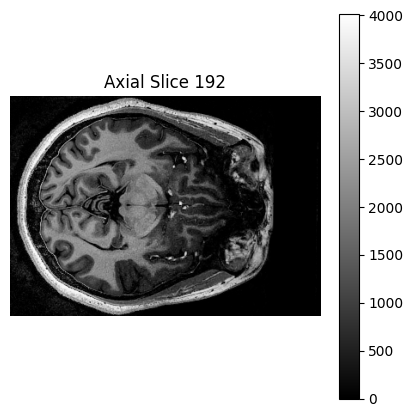

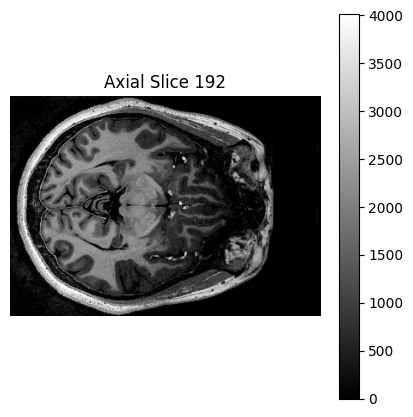

In [9]:
import matplotlib.pyplot as plt

def show_slice(data, slice_index, plane="axial"):
    plt.figure(figsize=(5, 5))
    if plane == "axial":
        plt.imshow(data[:, :, slice_index], cmap="gray")
        plt.title(f"Axial Slice {slice_index}")
    elif plane == "coronal":
        plt.imshow(data[:, slice_index, :], cmap="gray")
        plt.title(f"Coronal Slice {slice_index}")
    elif plane == "sagittal":
        plt.imshow(data[slice_index, :, :], cmap="gray")
        plt.title(f"Sagittal Slice {slice_index}")
    plt.axis("off")
    plt.colorbar()
    plt.show()

# Display slices
show_slice(nifti_data, nifti_data.shape[2] // 2, plane="axial")
show_slice(dicom_volume, dicom_volume.shape[2] // 2, plane="axial")


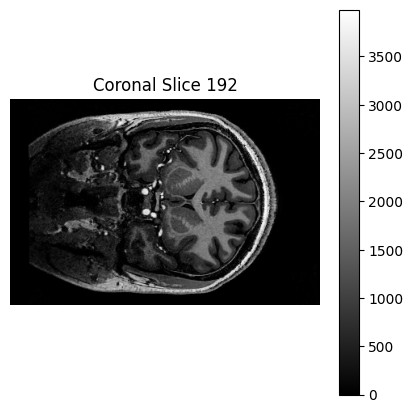

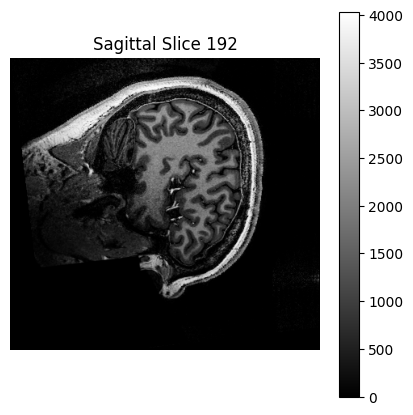

In [11]:
show_slice(nifti_data, nifti_data.shape[2] // 2, plane="coronal")
show_slice(nifti_data, nifti_data.shape[2] // 2, plane="sagittal")

Affine matrices

In [12]:
## NIfTI orientation using affine
print("Affine matrix (NIfTI):\n", nifti_img.affine)

## DICOM orientation using tags
print("Image Orientation Patient (DICOM):", ds.get("ImageOrientationPatient", "Unknown"))

Affine matrix (NIfTI):
 [[ 6.29074156e-01 -1.33072212e-02 -3.11387163e-02 -7.36054077e+01]
 [ 1.63442213e-02  6.21981978e-01  5.91654330e-02 -1.00073349e+02]
 [ 2.99664345e-02 -5.98863661e-02  6.21413589e-01 -1.19990189e+02]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]
Image Orientation Patient (DICOM): [1.0, 0.0, 0.0, 0.0, 1.0, 0.0]


In [ ]:
"""
Part 5: How to Interpret Image Orientation


NIfTI Orientation: The Affine Matrix

In NIfTI, orientation is handled by a 4×4 affine transformation matrix stored in the image header.

The matrix looks like:

    | a11  a12  a13  tx |
    | a21  a22  a23  ty |
    | a31  a32  a33  tz |
    |  0    0    0    1 |

- The 3×3 block encodes rotation, scaling (voxel spacing), and shearing.
- The last column [tx, ty, tz] gives the real-world position of the first voxel (origin).

Affine tells us:
- Voxel spacing (mm),
- Image rotation (which way is left/right, top/bottom, etc.),
- Where the image volume is located in patient space.

DICOM

In DICOM, each 2D slice has its own metadata defining orientation. The key fields are:

1. ImageOrientationPatient:
   - A set of 6 values = 2 direction vectors:
     - First 3 = direction of image rows,
     - Next 3 = direction of image columns.

2. ImagePositionPatient :
   - A 3D coordinate (x, y, z) of the top-left corner of the image.

3. PixelSpacing :
   - Physical spacing between pixels (row spacing, column spacing) in mm.

These define how each slice is positioned and oriented in patient space.
When stacking slices, the slice normal vector (cross product of row and column directions) helps determine correct ordering.


"""


In [ ]:
'''Part 6: Differences between DICOM and NIfTI

Summary of Differences

 Use-case:
  - DICOM: Clinical imaging, widely used in hospitals.
   - NIfTI: Research, especially neuroimaging.

 Storage:
   - DICOM: One slice per `.dcm` file (multi-file series).
   - NIfTI: Entire volume in one `.nii` file.

 Metadata:
   - DICOM: Rich, detailed, per-slice metadata ( Patient ID, scanner settings).
   - NIfTI: mainly spatial metadata ( affine, voxel spacing).

 Orientation:
   - DICOM: `ImagePositionPatient`, `ImageOrientationPatient` tags.
   - NIfTI: Affine transformation matrix.

 Ease of use in Python:
   - NIfTI (way easier): Read single file with nibabel.
   - DICOM: Requires sorting and stacking with pydicom.
   '''
